В домашнем задании нужно решить задачу регрессии. В качестве датасета необходимо взять данные о недвижимости Калифорнии.
Целевая переменная – MedHouseVal. На полученных данных построить модель регрессии и дерево решений.

In [916]:
from sklearn.datasets import fetch_california_housing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

1. Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую).

In [917]:
print(fetch_california_housing().DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [918]:
housing = fetch_california_housing()

In [919]:
housing.data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [920]:
housing.target

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [921]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [922]:
# Преобразуем данные в таблицу

data = pd.DataFrame(data=housing.data, columns=housing.feature_names)
data['MedHouseVal'] = housing.target
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


2. Проведите первичный анализ.
* Проверьте данные на пропуски. Удалите в случае обнаружения.
* Нормализуйте один из признаков.

In [923]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [924]:
data['MedHouseVal'].value_counts().sort_values()

0.47000      1
2.91100      1
2.95700      1
3.06600      1
3.32300      1
          ... 
1.87500     93
1.12500    103
1.62500    117
1.37500    122
5.00001    965
Name: MedHouseVal, Length: 3842, dtype: int64

In [925]:
data['MedHouseVal'].sort_values().unique()

array([0.14999, 0.175  , 0.225  , ..., 4.991  , 5.     , 5.00001])

In [926]:
data['MedInc'].sort_values().unique()

array([ 0.4999,  0.536 ,  0.5495, ..., 14.9009, 15.    , 15.0001])

In [927]:
# Построим корреляционную матрицу

corr_matrix = data.corr()
corr_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


Text(0.5, 1.0, 'Корреляционная матрица признаков')

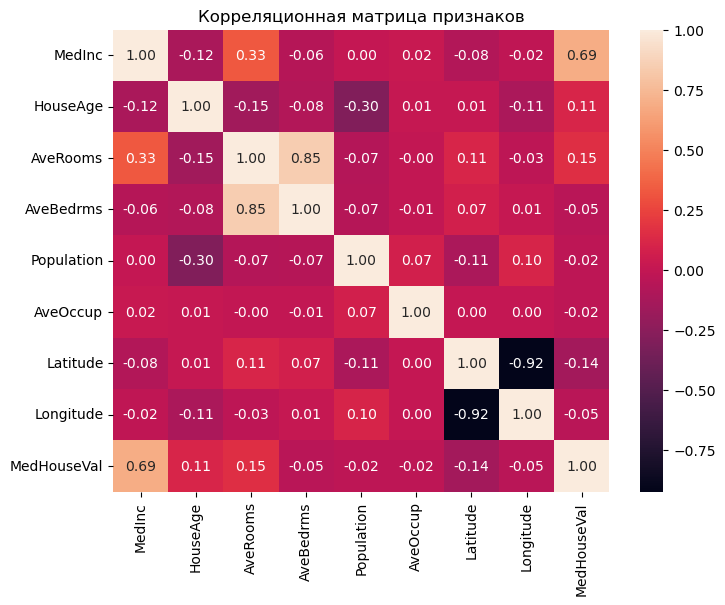

In [928]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')

plt.title('Корреляционная матрица признаков')

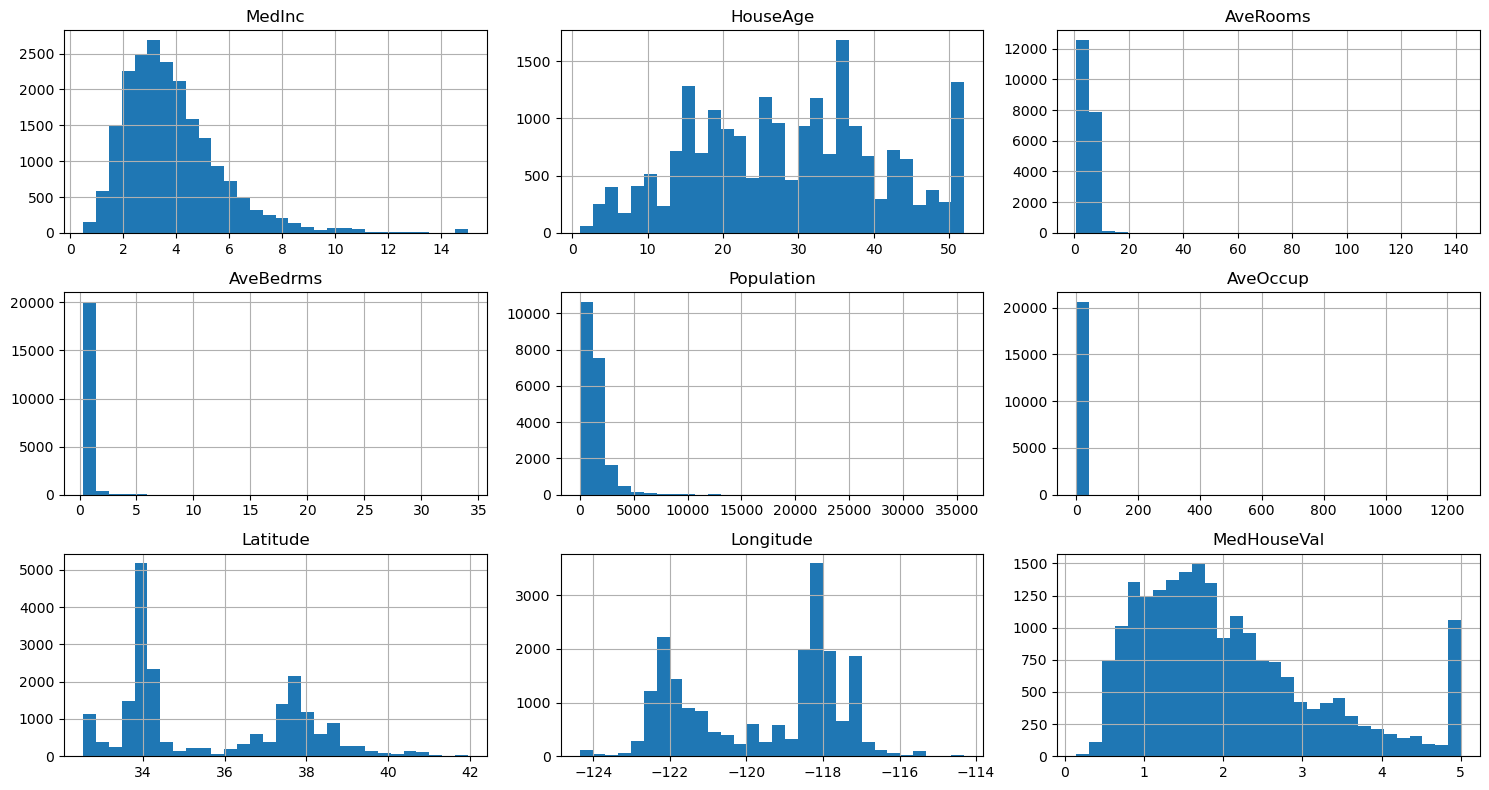

In [929]:
# Рассмотрим распределение признаков на графике

data.hist(figsize=(15, 8), bins=30)
plt.tight_layout()
plt.show()  

3. Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.

In [930]:
X = data[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
y = data['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Обучите модель регрессии на обучающем множестве.

In [931]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

5. Для тестового множества предскажите целевую переменную и сравните с истинным значением, посчитав точность предсказания модели. Для этого используйте встроенную функцию score.

In [932]:
y_test_pred = model.predict(X_test)
y_test_pred

array([0.71912284, 1.76401657, 2.70965883, ..., 4.46877017, 1.18751119,
       2.00940251])

In [933]:
# Оценим R2 на тестовой выборке на исходных данных

r2 = r2_score(y_test, y_test_pred)
print(f'Тестовая выборка без преобразований: R2 = {r2:.3f}')

Тестовая выборка без преобразований: R2 = 0.576


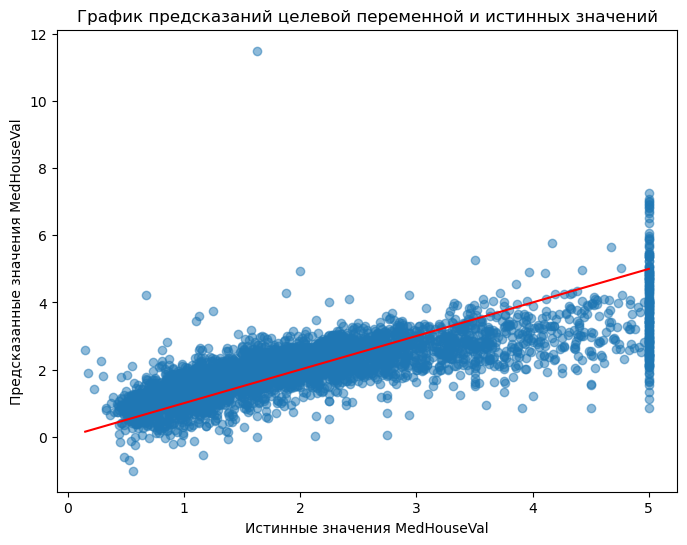

In [934]:
# Построим график предсказаний целевой переменной MedHouseVal

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-')  # линия регрессии
plt.xlabel('Истинные значения MedHouseVal')
plt.ylabel('Предсказанные значения MedHouseVal')
plt.title('График предсказаний целевой переменной и истинных значений')
plt.show()

In [935]:
# Преобразуем асимметричные распределения с помощью логарифмирования

features_scaler = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

for feature in features_scaler:
    data[feature] = np.log1p(data[feature])

In [936]:
X = data[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
y = data['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

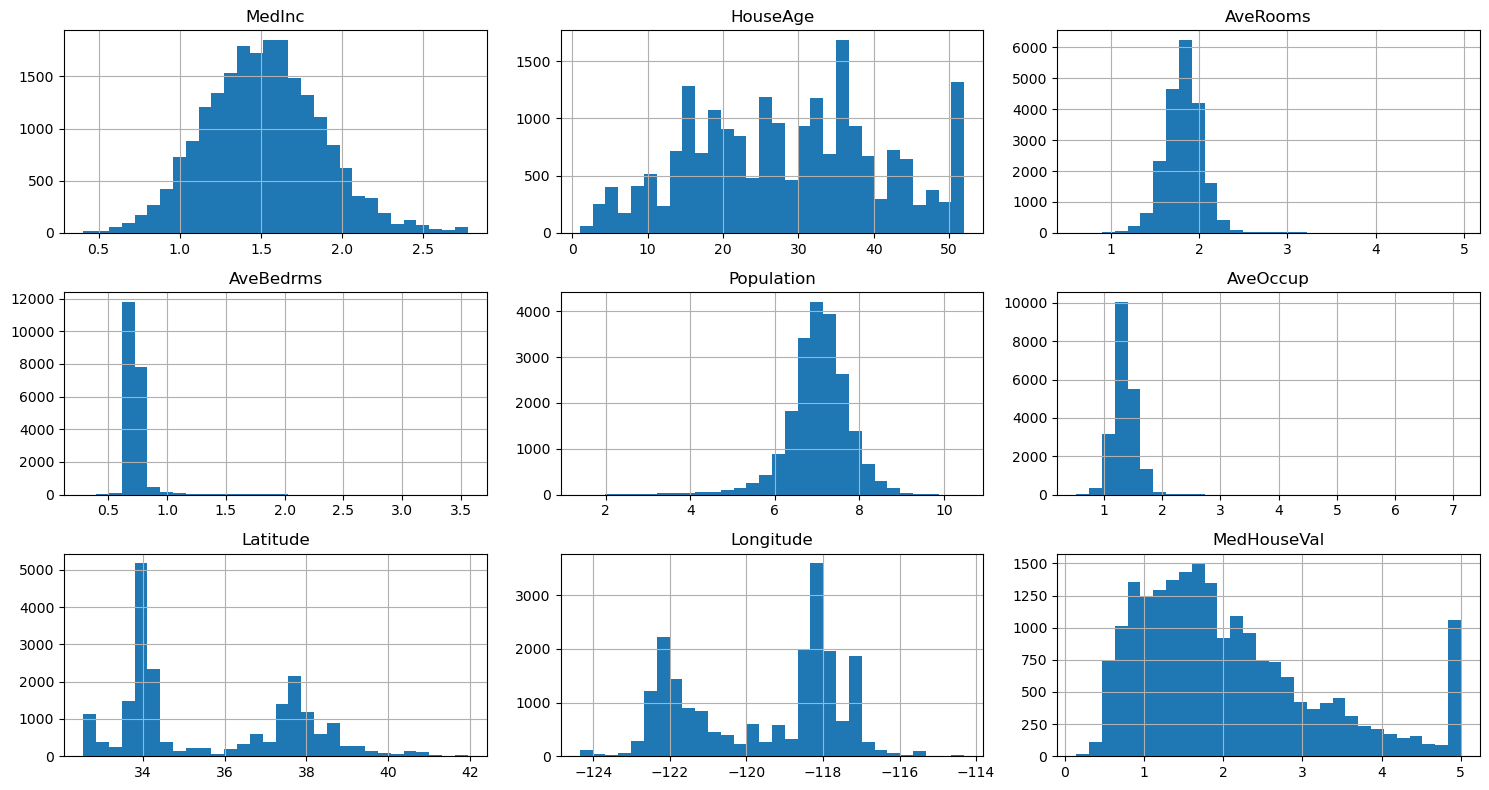

In [937]:
# Оценим распределение признаков на графике после логарифмирования

data.hist(figsize=(15, 8), bins=30)
plt.tight_layout()
plt.show()  

In [938]:
# Обучим модель на преобразованных признаках

model = LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

In [939]:
# Оценим R2 на тестовой выборке после преобразований log - метрика стала немного лучше

r2 = r2_score(y_test, y_test_pred)
print(f'Тестовая выборка логарифмирование: R2 = {r2:.3f}')

Тестовая выборка логарифмирование: R2 = 0.611


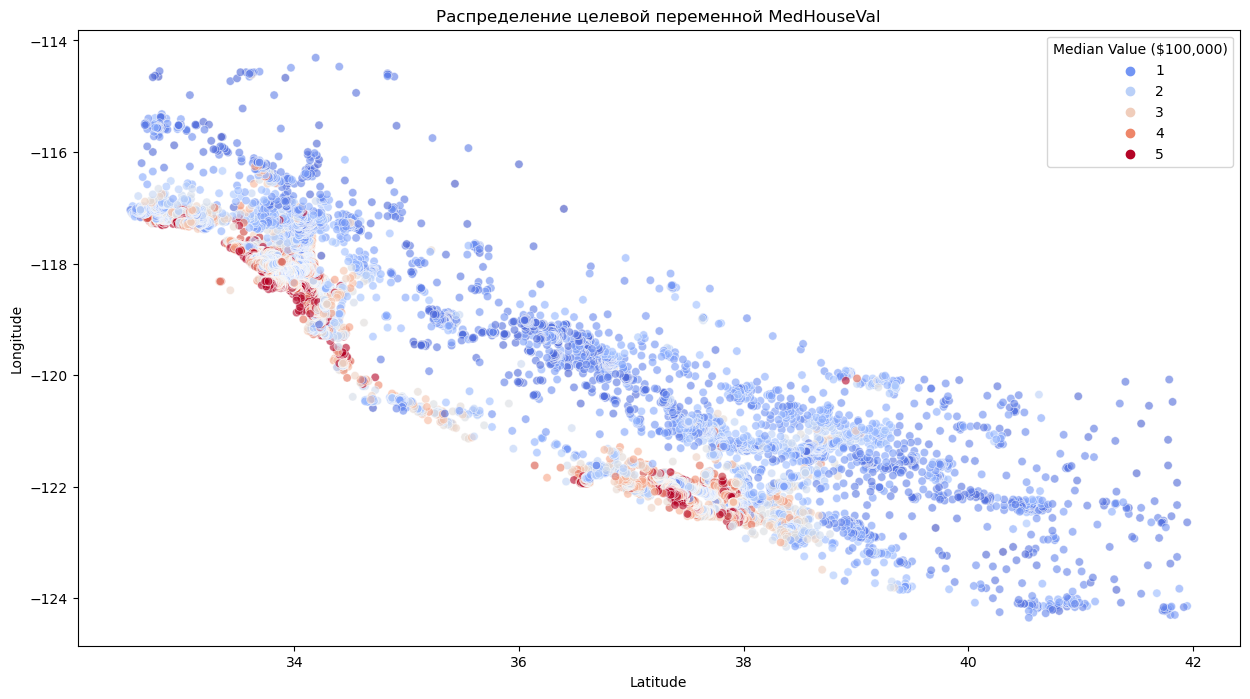

In [940]:
# Оценим распределение MedHouseVal в зависимости от положения по Latitude, Longitude

plt.figure(figsize=(15, 8))

sns.scatterplot(
    x='Latitude', 
    y='Longitude', 
    data=data, 
    hue='MedHouseVal',  
    palette="coolwarm",       
    alpha=0.6       
)

plt.title('Распределение целевой переменной MedHouseVal')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(title='Median Value ($100,000)')
plt.show()

In [941]:
# Подтвердим по геопозиции предположение относительно расположения у береговой линии

min_value = data['MedHouseVal'].min()

min_rows = data[data['MedHouseVal'] == min_value]
min_rows

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
2521,0.978589,16.0,2.042586,1.071944,4.454347,1.174598,39.71,-122.74,0.14999
2799,1.131402,19.0,1.563266,0.899070,6.196444,1.383241,36.40,-117.02,0.14999
9188,1.647350,52.0,1.519270,0.782378,6.444131,1.332659,34.24,-117.86,0.14999
19802,0.429182,36.0,2.583998,1.504077,2.944439,1.178655,40.31,-123.17,0.14999


In [942]:
# Выделим новый столбец MedHouseVal_category с категориями стоимости домов

bins = pd.cut(data['MedHouseVal'], bins=5, labels=['Very_Low', 'Low', 'Average', 'High', 'Very_High'])
data['MedHouseVal_category'] = bins
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,MedHouseVal_category
0,2.232720,41.0,2.077455,0.704982,5.777652,1.268511,37.88,-122.23,4.526,Very_High
1,2.230165,21.0,1.979364,0.678988,7.784057,1.134572,37.86,-122.22,3.585,High
2,2.111110,52.0,2.228738,0.729212,6.208590,1.335596,37.85,-122.24,3.521,High
3,1.893579,52.0,1.919471,0.729025,6.326149,1.266369,37.85,-122.25,3.413,High
4,1.578195,52.0,1.985385,0.732888,6.338594,1.157342,37.85,-122.25,3.422,High


In [943]:
data_bin = data.groupby('MedHouseVal_category')[['Latitude', 'Longitude']].mean().reset_index()
data_bin

,MedHouseVal_category,Latitude,Longitude
0,Very_Low,36.584487,-119.769312
1,Low,35.350630,-119.262736
2,Average,35.365891,-119.680131
3,High,35.486173,-119.906549
4,Very_High,35.307805,-119.769890


In [944]:
# Используем One-Hot Encoding для преобразования нового столбца

data_encoded = pd.get_dummies(data, columns=['MedHouseVal_category'])
data_encoded.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,MedHouseVal_category_Very_Low,MedHouseVal_category_Low,MedHouseVal_category_Average,MedHouseVal_category_High,MedHouseVal_category_Very_High
0,2.232720,41.0,2.077455,0.704982,5.777652,1.268511,37.88,-122.23,4.526,0,0,0,0,1
1,2.230165,21.0,1.979364,0.678988,7.784057,1.134572,37.86,-122.22,3.585,0,0,0,1,0
2,2.111110,52.0,2.228738,0.729212,6.208590,1.335596,37.85,-122.24,3.521,0,0,0,1,0
3,1.893579,52.0,1.919471,0.729025,6.326149,1.266369,37.85,-122.25,3.413,0,0,0,1,0
4,1.578195,52.0,1.985385,0.732888,6.338594,1.157342,37.85,-122.25,3.422,0,0,0,1,0


In [945]:
data_encoded.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'MedHouseVal_category_Very_Low',
       'MedHouseVal_category_Low', 'MedHouseVal_category_Average',
       'MedHouseVal_category_High', 'MedHouseVal_category_Very_High'],
      dtype='object')

In [946]:
# Обучим модель с учетом новых призаков по расположению у океана

X = data_encoded[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal_category_Very_Low',
       'MedHouseVal_category_Low', 'MedHouseVal_category_Average',
       'MedHouseVal_category_High', 'MedHouseVal_category_Very_High']]
y = data_encoded['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [947]:
model = LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

In [948]:
# Значительно улучшили результат предсказаний модели

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
print(f'Тестовая выборка итог: RMSE = {rmse:.3f}, R2 = {r2:.3f}')

Тестовая выборка итог: RMSE = 0.245, R2 = 0.954


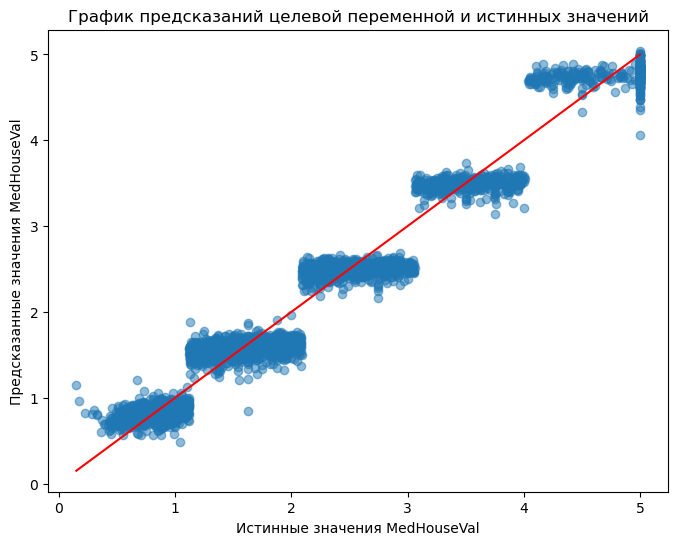

In [949]:
# Построим график предсказаний целевой переменной MedHouseVal

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-')  # линия регрессии
plt.xlabel('Истинные значения MedHouseVal')
plt.ylabel('Предсказанные значения MedHouseVal')
plt.title('График предсказаний целевой переменной и истинных значений')
plt.show()

6. Обучите дерево решений на обучающем множестве.
* Повторите п. 5 для полученной модели.
* Визуализируйте часть дерева решений.

In [950]:
X = housing.data
y = housing.target

In [951]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [952]:
# Обучим дерево без ограничений

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [953]:
rmse_ = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_ = r2_score(y_train, y_train_pred)
print(f"Тренировочная выборка с ограничением глубины дерева: RMSE = {rmse_:.3f}, R2 = {r2_:.3f}")

Тренировочная выборка с ограничением глубины дерева: RMSE = 0.000, R2 = 1.000


In [954]:
rmse_ = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_ = r2_score(y_test, y_test_pred)
print(f"Тестовая выборка с ограничением глубины дерева: RMSE = {rmse_:.3f}, R2 = {r2_:.3f}")

Тестовая выборка с ограничением глубины дерева: RMSE = 0.707, R2 = 0.619


In [955]:
# Без ограничений получаем переобучение, теперь попробуем ограничить глубину max_depth=3

In [956]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [957]:
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)
y_test_pred = tree.predict(X_test)

In [958]:
rmse_ = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_ = r2_score(y_test, y_test_pred)
print(f'Тестовая выборка с ограничением глубины дерева: RMSE = {rmse_:.3f}, R2 = {r2_:.3f}')

Тестовая выборка с ограничением глубины дерева: RMSE = 0.802, R2 = 0.510


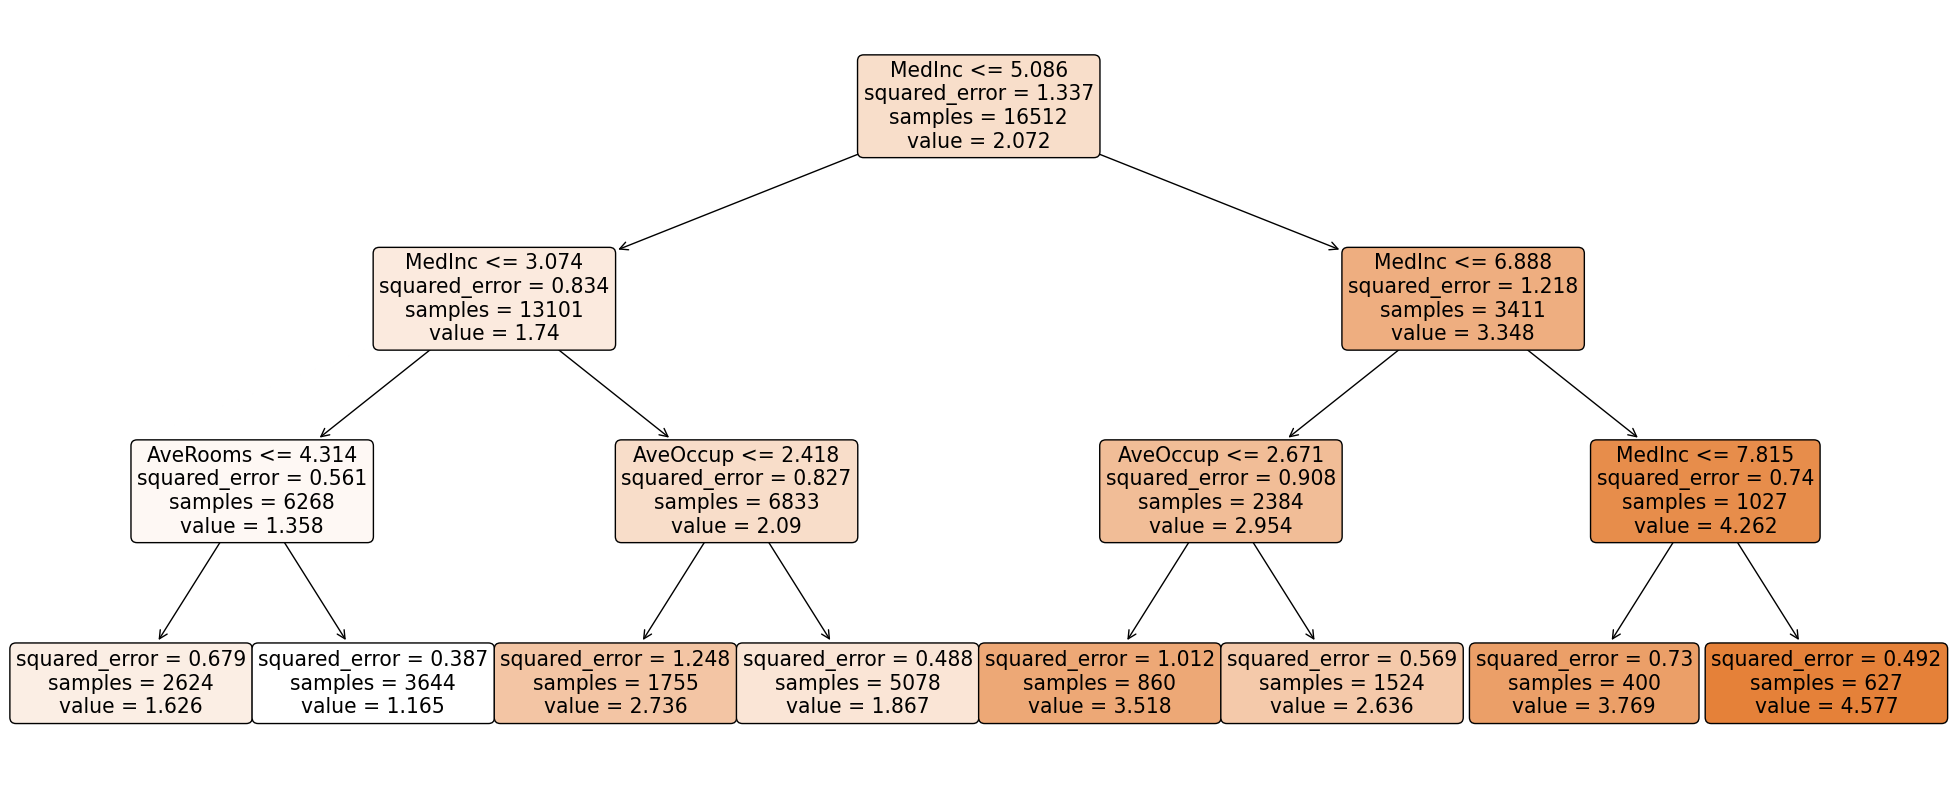

In [959]:
# Визуализируем часть дерева решений 

plt.figure(figsize=(25, 10))
plot_tree(tree,
          feature_names=housing.feature_names,
          filled=True,
          rounded=True)
plt.show()

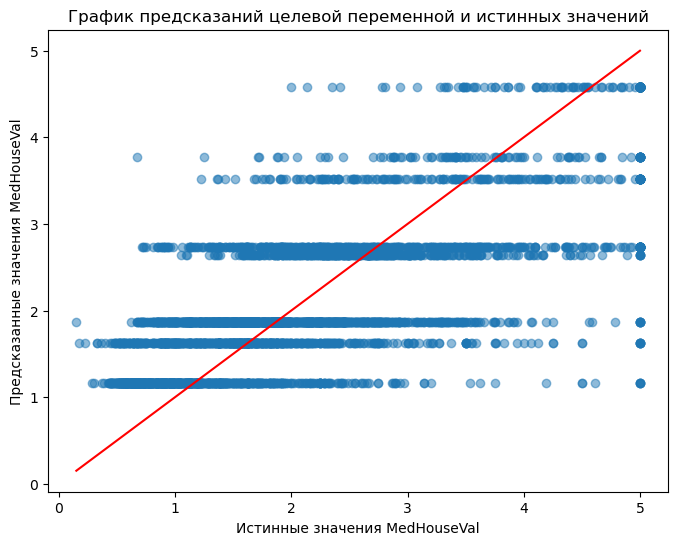

In [960]:
# Построим график предсказаний целевой переменной MedHouseVal

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-')  # линия регрессии
plt.xlabel('Истинные значения MedHouseVal')
plt.ylabel('Предсказанные значения MedHouseVal')
plt.title('График предсказаний целевой переменной и истинных значений')
plt.show()

7. Оптимизируйте глубину дерева (max_depth). *Оптимизируйте ещё один параметр модели на выбор. Повторите п. 5 для полученной модели.

In [961]:
# Увеличение глубины - увеличивает скор, оставим его без ограничений
# Ограничим число образцов в листовом узле

tree = DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
tree.fit(X_train, y_train)
y_test_pred = tree.predict(X_test)

In [962]:
rmse_ = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_ = r2_score(y_test, y_test_pred)
print(f'Тестовая выборка дерево с ограничением по листам: RMSE = {rmse_:.3f}, R2 = {r2_:.3f}')

Тестовая выборка дерево с ограничением по листам: RMSE = 0.603, R2 = 0.722


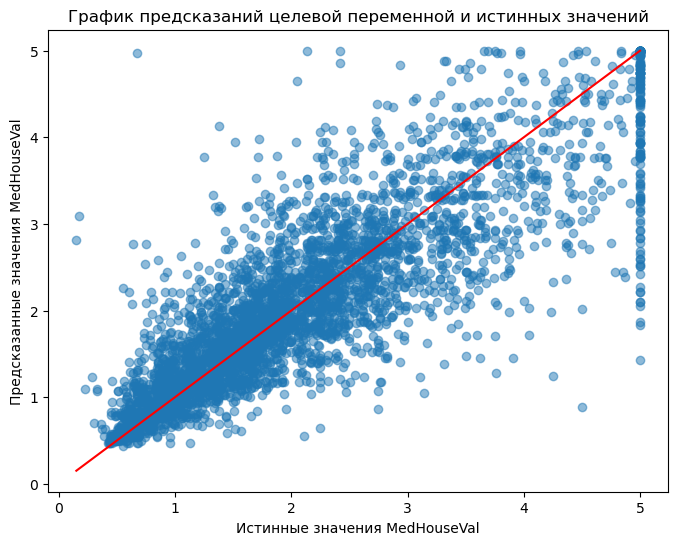

In [963]:
# Построим график предсказаний целевой переменной MedHouseVal

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-')  # линия регрессии
plt.xlabel('Истинные значения MedHouseVal')
plt.ylabel('Предсказанные значения MedHouseVal')
plt.title('График предсказаний целевой переменной и истинных значений')
plt.show()

In [964]:
data_encoded.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,MedHouseVal_category_Very_Low,MedHouseVal_category_Low,MedHouseVal_category_Average,MedHouseVal_category_High,MedHouseVal_category_Very_High
0,2.232720,41.0,2.077455,0.704982,5.777652,1.268511,37.88,-122.23,4.526,0,0,0,0,1
1,2.230165,21.0,1.979364,0.678988,7.784057,1.134572,37.86,-122.22,3.585,0,0,0,1,0
2,2.111110,52.0,2.228738,0.729212,6.208590,1.335596,37.85,-122.24,3.521,0,0,0,1,0
3,1.893579,52.0,1.919471,0.729025,6.326149,1.266369,37.85,-122.25,3.413,0,0,0,1,0
4,1.578195,52.0,1.985385,0.732888,6.338594,1.157342,37.85,-122.25,3.422,0,0,0,1,0


In [965]:
X = data_encoded[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal_category_Very_Low',
       'MedHouseVal_category_Low', 'MedHouseVal_category_Average',
       'MedHouseVal_category_High', 'MedHouseVal_category_Very_High']]
y = data_encoded['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [966]:
tree = DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
tree.fit(X_train, y_train)
y_test_pred = tree.predict(X_test)

In [967]:
rmse_ = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_ = r2_score(y_test, y_test_pred)
print(f'Тестовая выборка дерево на преобразованных признаках: RMSE = {rmse_:.3f}, R2 = {r2_:.3f}')

Тестовая выборка дерево на преобразованных признаках: RMSE = 0.260, R2 = 0.948


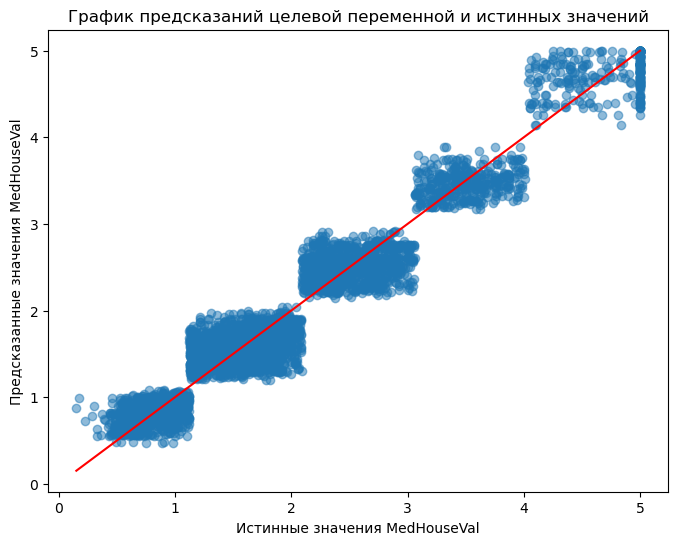

In [968]:
# Построим график предсказаний целевой переменной MedHouseVal

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-')  # линия регрессии
plt.xlabel('Истинные значения MedHouseVal')
plt.ylabel('Предсказанные значения MedHouseVal')
plt.title('График предсказаний целевой переменной и истинных значений')
plt.show()

8. Сформулируйте выводы по проделанной работе.
* Сравните точность двух моделей.
* Напишите свое мнение, для каких задач предпочтительнее использовать обученные в работе модели? Какие у них есть плюсы и минусы?

### В данной задаче наибольшее влияние оказал фактор обработки входных параметров, а именно преобразование долготы и широты в один параметр. Результаты моделей при использовании преобразований близки.

In [972]:
print(f'LinearRegression: RMSE:{rmse:.3f}, R2:{r2:.3f}; \nDecisionTreeRegressor: RMSE:{rmse_:.3f}, R2:{r2_:.3f}')


LinearRegression: RMSE:0.245, R2:0.954; 
DecisionTreeRegressor: RMSE:0.260, R2:0.948
